In [1]:
import pyximport
import numpy as np
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN
import pandas as pd
from surprise import Dataset, Reader, accuracy, NMF
from surprise.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\pmuellner\Desktop\DataLeakageKNN\algorithms\knn_neighborhood.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


# Read data 

In [77]:
data_df = pd.read_csv("data/ml-100k/u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
#data_df = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["user_id", "item_id", "rating", "timestamp"])
#data_df = pd.read_csv("data/jester/sample.csv", sep=";", names=["user_id", "item_id", "rating"])
data_df.drop(columns=["timestamp"], axis=1, inplace=True)

#user_sample = np.random.choice(data_df["user_id"].unique(), size=1000, replace=False)
#data_df = data_df[data_df["user_id"].isin(user_sample)]

data_df["user_id"] = data_df["user_id"].map({b: a for a, b in enumerate(data_df["user_id"].unique())})
data_df["item_id"] = data_df["item_id"].map({b: a for a, b in enumerate(data_df["item_id"].unique())})

In [78]:
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data_df, reader=reader)
trainset, testset = train_test_split(dataset, test_size=0.2)

sim = UserKNN.compute_similarities(trainset, min_support=1)
pop = UserKNN.compute_popularities(trainset)
gain = UserKNN.compute_gain(trainset)

In [80]:
def mentors_at_q(model):
    q_max = np.max([len(nmentors) for nmentors in model.n_mentors_at_q.values()])
    avg_n_mentors_at_q = [0]
    n_students_at_q = [trainset.n_users]
    for q in range(1, q_max+1):
        avg_at_q = []
        n = 0
        for iuid, mentors in model.n_mentors_at_q.items():
            if len(mentors) >= q:
                avg_at_q.append(mentors[q-1])
                n += 1
        avg_n_mentors_at_q.append(np.mean(avg_at_q))
        n_students_at_q.append(n)
    
    return avg_n_mentors_at_q, n_students_at_q

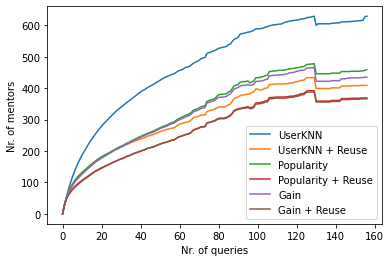

In [94]:
K = 30

# KNN
model = UserKNN(k=K, precomputed_sim=sim)
model.fit(trainset)
_ = model.test(testset)
avg_n_mentors_at_q, n_students_at_q = mentors_at_q(model)
plt.plot(avg_n_mentors_at_q, color="C0", label="UserKNN", alpha=1)

# KNN + reuse
model = UserKNN(k=K, reuse=True, precomputed_sim=sim)
model.fit(trainset)
_ = model.test(testset)
avg_n_mentors_at_q, n_students_at_q = mentors_at_q(model)
plt.plot(avg_n_mentors_at_q, color="C1", label="UserKNN + Reuse")

# Popularity
model = UserKNN(k=K, precomputed_sim=sim, precomputed_pop=pop, tau_2=0.5)
model.fit(trainset)
_ = model.test(testset)
avg_n_mentors_at_q, n_students_at_q = mentors_at_q(model)
plt.plot(avg_n_mentors_at_q, color="C2", label="Popularity")

# Popularity + reuse
model = UserKNN(k=K, reuse=True, precomputed_sim=sim, precomputed_pop=pop, tau_2=0.5)
model.fit(trainset)
_ = model.test(testset)
avg_n_mentors_at_q, n_students_at_q = mentors_at_q(model)
plt.plot(avg_n_mentors_at_q, color="C3", label="Popularity + Reuse")

# Gain
model = UserKNN(k=K, precomputed_sim=sim, precomputed_gain=gain, tau_4=0.5)
model.fit(trainset)
_ = model.test(testset)
avg_n_mentors_at_q, n_students_at_q = mentors_at_q(model)
plt.plot(avg_n_mentors_at_q, color="C4", label="Gain")

# Gain + reuse
model = UserKNN(k=K, reuse=True, precomputed_sim=sim, precomputed_gain=gain, tau_4=0.5)
model.fit(trainset)
_ = model.test(testset)
avg_n_mentors_at_q, n_students_at_q = mentors_at_q(model)
plt.plot(avg_n_mentors_at_q, color="C5", label="Gain + Reuse")


#plt.plot(n_students_at_q, color="gray", label="Nr. of students", alpha=0.5)

plt.xlabel("Nr. of queries")
plt.ylabel("Nr. of mentors")
plt.legend()
#plt.savefig("plots/mentors/nmentors_k30_online.png", dpi=300)